# Appliances Electricity Usage Prediction
                                                           

In [1]:
import pandas as pd
import numpy as np

pd.set_option("display.max_columns", None)
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
matplotlib.style.use('ggplot')


### Read Data

In [2]:
df=pd.read_csv('C:/Users/dxs19/Desktop/Machine Learning Problem/Dataset.csv',parse_dates=['date'])

In [3]:
# Lowercase the column names
df.columns = [x.lower() for x in df.columns]

#df.isna().any()

# Set datetime index due to time series analysis 
df = df.set_index('date')

In [4]:
print("Number of instances in dataset = {}".format(df.shape[0]))
print("Total number of columns = {}".format(df.columns.shape[0]))
print("Column wise count of null values:-")

# Missing values
print(df.isnull().sum())

Number of instances in dataset = 19735
Total number of columns = 28
Column wise count of null values:-
appliances     0
lights         0
t1             0
rh_1           0
t2             0
rh_2           0
t3             0
rh_3           0
t4             0
rh_4           0
t5             0
rh_5           0
t6             0
rh_6           0
t7             0
rh_7           0
t8             0
rh_8           0
t9             0
rh_9           0
t_out          0
press_mm_hg    0
rh_out         0
windspeed      0
visibility     0
tdewpoint      0
rv1            0
rv2            0
dtype: int64


* Missing value Imputation- There are no missing values in the data
* Irregularity in data - There aren't any NA values for all variables
* Outliers - After deep diving into the dataset, We noticed that there are outliers in appliance variable


The number of the 0,1% top values of appliances' load is 19 and they have power load higher than 790 Wh.


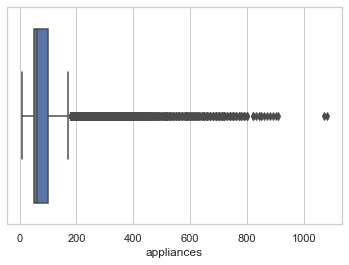

In [5]:
# Find outliers
sorted_appliances = df.sort_values('appliances',ascending=False)
print("The number of the 0,1% top values of appliances' load is",
      len(sorted_appliances.head(len(sorted_appliances)//1000)),"and they have power load higher than",
      sorted_appliances.appliances[19], "Wh.")

# boxplot appliances
sns.set(style="whitegrid")
ax = sns.boxplot(sorted_appliances.appliances)


Outlier treatment:
Here we excluded the absolute 0 values and 1% top values of appliances load because power load higher than 800Wh does not seem to be logical.
The idea is to segment the time in hours, day, week and month as the appliances load is dependent on them.  It seems logical to say that less energy is consumed in night hours which implies that load is lower and also weekends will have higher consumption as compared to weekdays as people are usually at home.

Also, there seems to be a correlation between temperature/humidity and energy load. For example, the temperature is bound to rise in the kitchen as people will cook, hence higher consumption.

Additionally, to see if a load is higher or lower than the energy load average, we have to use qualitative predictors in any given time interval.

To find out which feature explains the appliances consumption more accurately, several columns of new features were added to the original data which also follows the all mentioned assumptions.


In [6]:
# Outliers removal

df = df.dropna()
df = df.drop(df[(df.appliances>790)|(df.appliances<0)].index)

In [7]:
#Added more columns to the Dataframe 
df['month'] = df.index.month
df['weekday'] = df.index.weekday
df['hour'] = df.index.hour
df['week'] = df.index.week


In [8]:
# Converted appliance into log appliance to normalize the data.
df['log_appliances'] = np.log(df.appliances)

# Average house temperature 
df['house_temp'] =(df.t1+df.t2+df.t3+df.t4+df.t5+df.t7+df.t8+df.t9)/8
# Average house humidity
df['house_hum'] =(df.rh_1+df.rh_2+df.rh_3+df.rh_4+df.rh_5+df.rh_7+df.rh_8+df.rh_9)/8


# Multiplied features to remove additive assumptions
df['hour*lights'] = df.hour * df.lights
df['t3rh3'] = df.t3 * df.rh_3
df['t2rh2'] = df.t2 * df.rh_2
df['t1rh1'] = df.t2 * df.rh_2
df['t5rh4'] = df.t2 * df.rh_2
df['t5rh5'] = df.t2 * df.rh_2
df['t6rh6'] = df.t2 * df.rh_2
df['t7rh7'] = df.t2 * df.rh_2
df['t8rh8'] = df.t2 * df.rh_2
df['t9rh9'] = df.t2 * df.rh_2

# Calculated average energy load per weekday and hour
# Created a function which gave us a new dictionary having keys as the unique categories of cat_feature 
# and values being the mean over real_feature. 

def code_mean(data, cat_feature, real_feature):
    
    return dict(data.groupby(cat_feature)[real_feature].mean())

# Averaged energy consumption per weekday and per hour
df['weekday_avg'] = list(map(
    code_mean(df[:], 'weekday', "appliances").get, df.weekday))
df['hour_avg'] = list(map(
    code_mean(df[:], 'hour', "appliances").get, df.hour))

In [9]:
# Using data sets of 30 minitues and 1 hour each instead of 10 minitues to reduce noise.

df_hour = df.resample('1H').mean()
df_30min =df.resample('30min').mean()

If the appliance consumption is lower than the hourly average consumption at any given point of time then we catergorize it as low consumption
whereas If the appliance consumption is higher than the hourly average consumption at any given point of time then we catergorize it as high consumption.
We can see various numbers below which came by several tryouts based on standard deviation of appliances' consumption.

In [11]:
# Qualitative predictors 


df['low_consum'] = (df.appliances+25<(df.hour_avg))*1
df['high_consum'] = (df.appliances+100>(df.hour_avg))*1

df_hour['low_consum'] = (df_hour.appliances+25<(df_hour.hour_avg))*1
df_hour['high_consum'] = (df_hour.appliances+25>(df_hour.hour_avg))*1

df_30min['low_consum'] = (df_30min.appliances+25<(df_30min.hour_avg))*1
df_30min['high_consum'] = (df_30min.appliances+35>(df_30min.hour_avg))*1


Plotting the graph between the appliances consumption and date over 4.5 months.

C:\Users\dxs19\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'Appliances consumption in Wh')

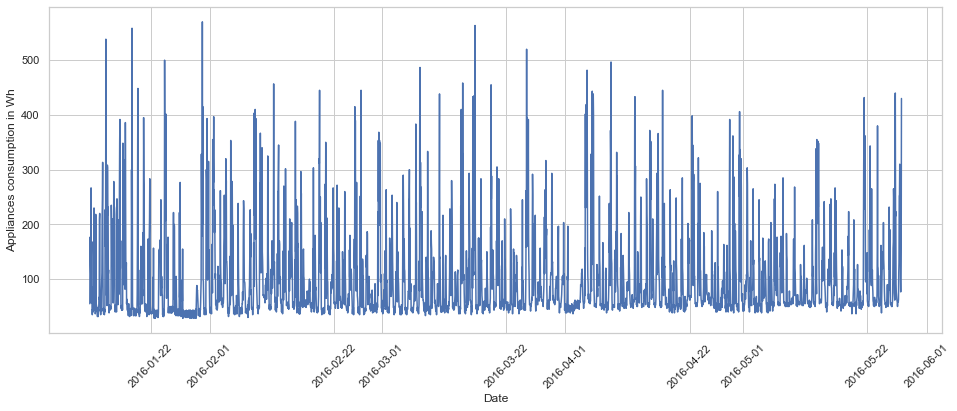

In [12]:
plt.figure(figsize=(16,6))
plt.plot(df_hour.appliances)
plt.xticks( rotation='45')
plt.xlabel('Date')
plt.ylabel('Appliances consumption in Wh')


In [13]:
# Functions to be used from the plots

def daily(x,df=df):
    return df.groupby('weekday')[x].mean()
def hourly(x,df=df):
    return df.groupby('hour')[x].mean()

def monthly_daily(x,df=df):
    by_day = df.pivot_table(index='weekday', 
                                columns=['month'],
                                values=x,
                                aggfunc='mean')
    return round(by_day, ndigits=2)

Plotting the graph of the mean energy consumption per day of week

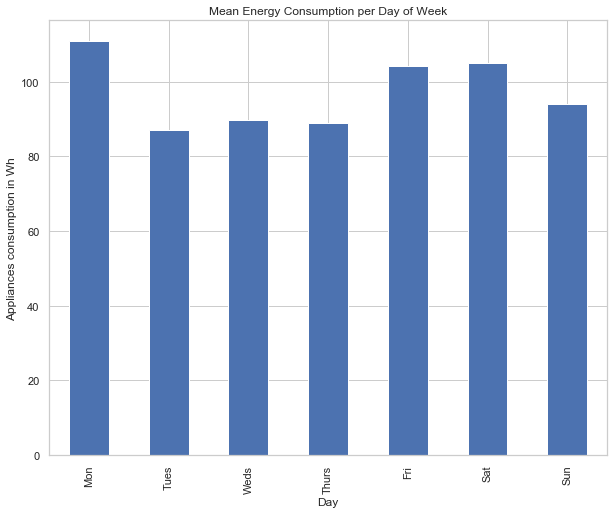

In [14]:
daily('appliances').plot(kind = 'bar', figsize=(10,8))
ticks = list(range(0, 7, 1)) 
labels = "Mon Tues Weds Thurs Fri Sat Sun".split()
plt.xlabel('Day')
plt.ylabel('Appliances consumption in Wh')
plt.title('Mean Energy Consumption per Day of Week')
plt.xticks(ticks, labels);

From the above plot, we can see that Monday has the highest consumption followed by weekends and Tuesday has the lowest.

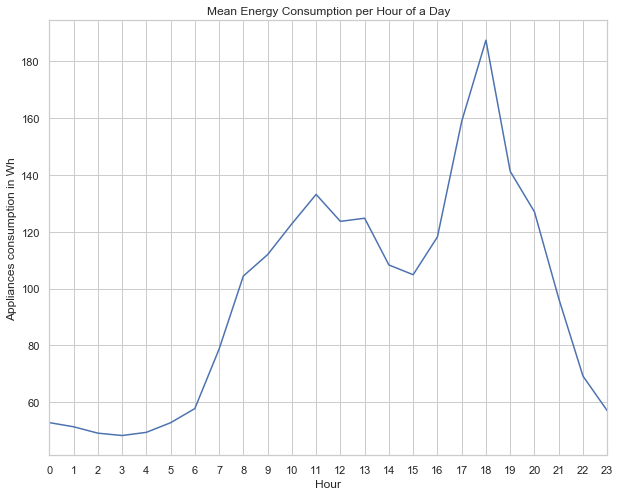

In [15]:
# Plotting the graph of the Mean Energy Consumption per Hour of a Day

hourly('appliances').plot(figsize=(10,8))
plt.xlabel('Hour')
plt.ylabel('Appliances consumption in Wh')
ticks = list(range(0, 24, 1))
plt.title('Mean Energy Consumption per Hour of a Day')

plt.xticks(ticks);

As mostly people do not use any appliances during the night hours, we can see that appliances consumptions is below 80 Wh from 10 pm to 7 am. During morning hours, the consumptions is between 120- 135 Wh. The highest consumption is between 4pm to 8pm where the consumption ranges from 120 Wh to 185 Wh,  when families are usually at home and using the appliances.  

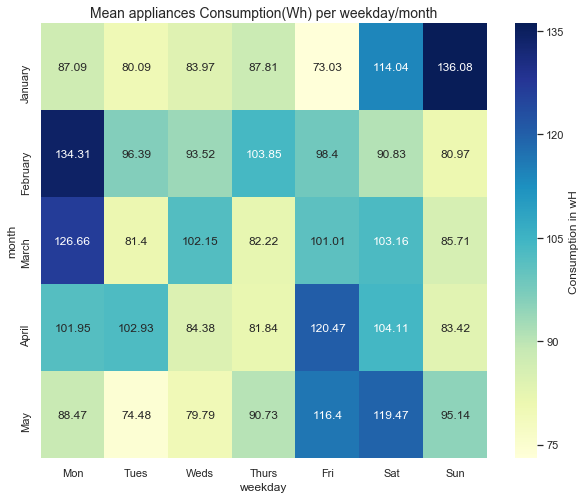

In [16]:
# Heatmap: Mean consumption per Weekday of Month
sns.set(rc={'figure.figsize':(10,8)},)
ax=sns.heatmap(monthly_daily('appliances').T,cmap="YlGnBu",
               xticklabels="Mon Tues Weds Thurs Fri Sat Sun".split(),
               yticklabels="January February March April May".split(),
               annot=True, fmt='g',
               cbar_kws={'label': 'Consumption in wH'}).set_title("Mean appliances Consumption(Wh) per weekday/month").set_fontsize('14')

plt.show()

From the above heatmap, we can interpret that more power is consumed on Monday, Friday, Saturday and Sunday in all the months. In our data set, we have only 4.5 months of data. Thus, we cannot use months as a feature for our model. 

Text(0.5, 0, 'Appliances log(wH)')

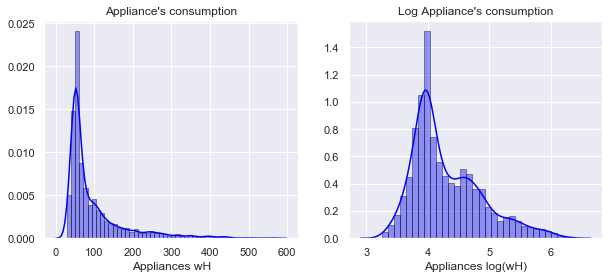

In [17]:
#Histogram of Appliance's consumption

f, axes = plt.subplots(1, 2,figsize=(10,4))

sns.distplot(df_hour.appliances, hist=True, color = 'blue',hist_kws={'edgecolor':'black'},ax=axes[0])
axes[0].set_title("Appliance's consumption")
axes[0].set_xlabel('Appliances wH')

sns.distplot(df_hour.log_appliances, hist=True, color = 'blue',hist_kws={'edgecolor':'black'},ax=axes[1])
axes[1].set_title("Log Appliance's consumption")
axes[1].set_xlabel('Appliances log(wH)')

The left plot depicts that the distrubution of the power load is not normally distributed. To make the analysis more accurate, log of power load is taken to normalize it.

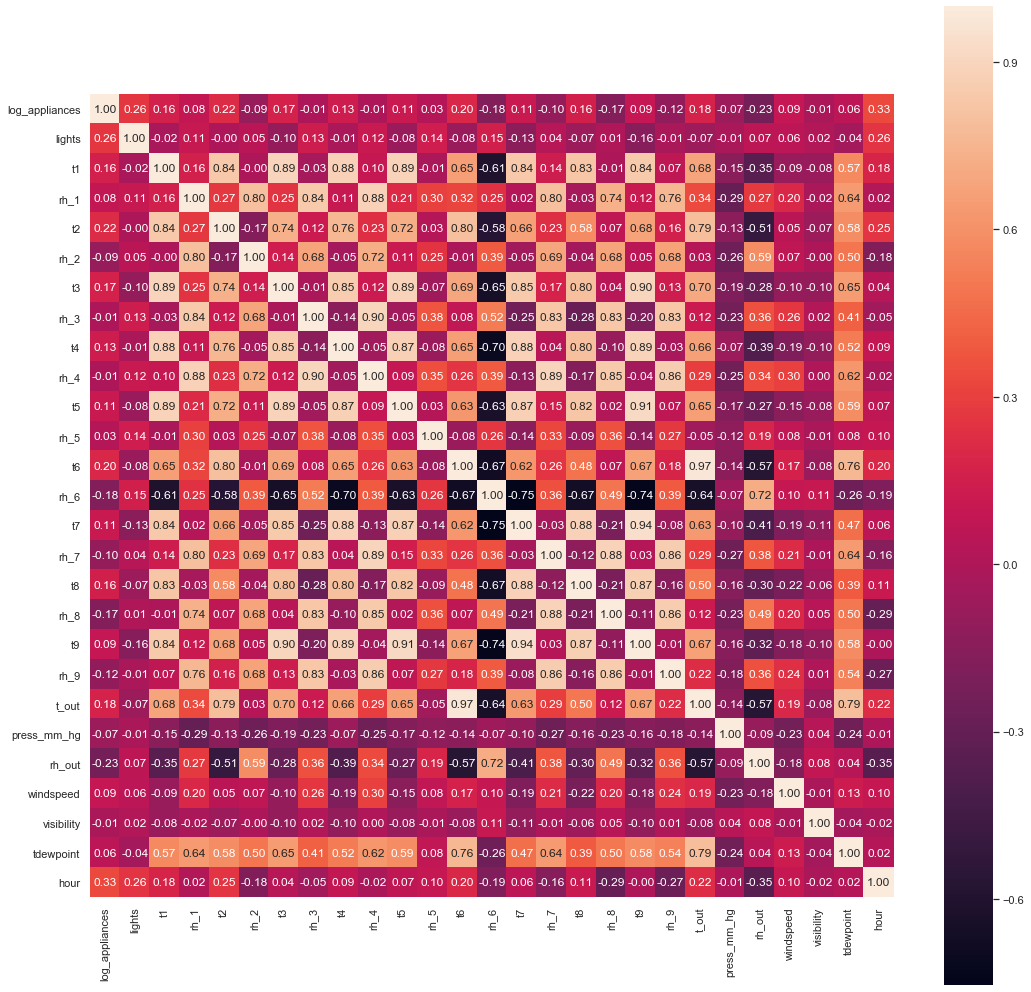

In [18]:
# Pearson Correlation among the variables
col = ['log_appliances', 'lights', 't1', 'rh_1', 't2', 'rh_2', 't3', 'rh_3', 't4',
       'rh_4', 't5', 'rh_5', 't6', 'rh_6', 't7', 'rh_7', 't8', 'rh_8', 't9',
       'rh_9', 't_out', 'press_mm_hg', 'rh_out', 'windspeed', 'visibility',
       'tdewpoint','hour']
corr = df[col].corr()
plt.figure(figsize = (18,18))
sns.set(font_scale=1)
sns.heatmap(corr, cbar = True, annot=True, square = True, fmt = '.2f', xticklabels=col, yticklabels=col)
plt.show();

The correlation plot shows high correlation between humidity and temperature features between different rooms which was expected. There is an unexpected negative correlation of RH_6(Humidity outside the building, in %) with other humidity measures. The trend of value shows that feature is highly variant from 100% to 0% from one date to another date. This can be due to some calibration issues of the device. In the further analysis, it might be better to remove this variable.


Next step is to examine linear dependence among some features of our data set. In a linear regression problem, linear independent variables are used as features to explain energy consumption to avoid multicollinearity issues.


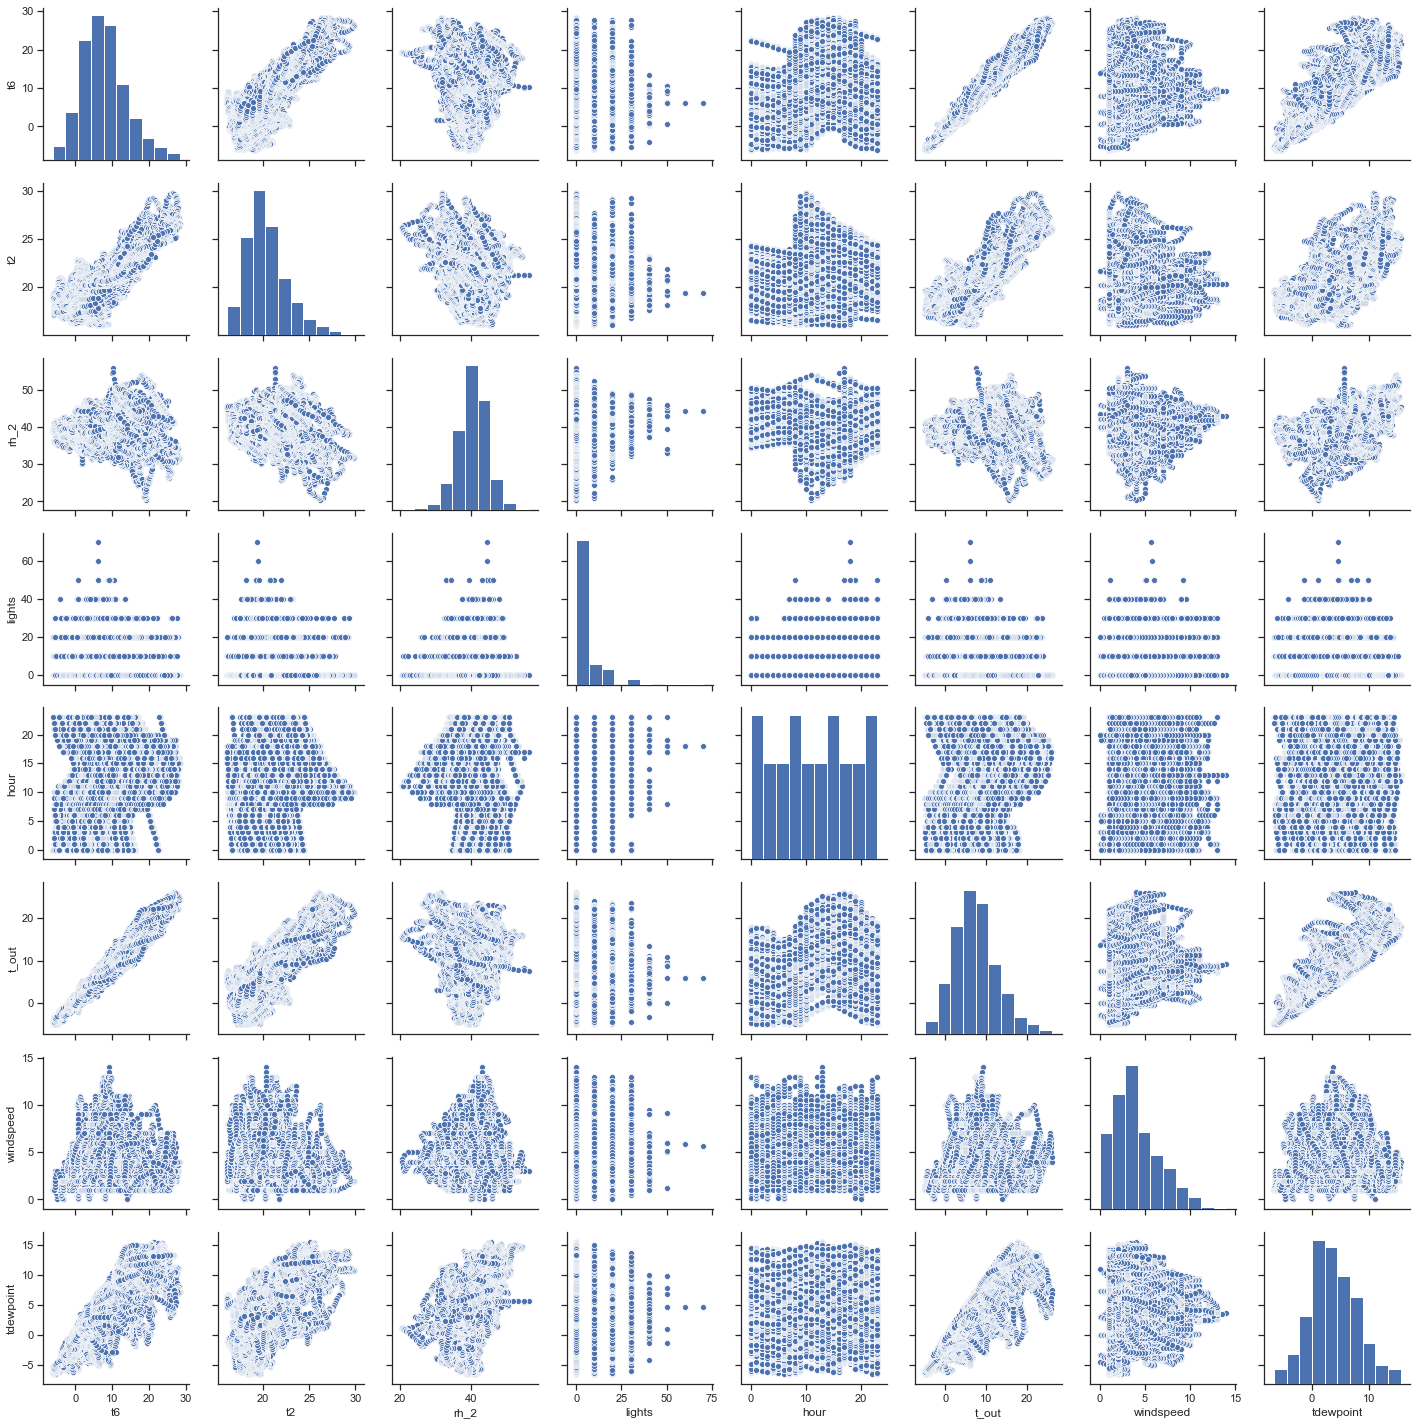

In [19]:
col = ['t6','t2', 'rh_2','lights','hour','t_out','windspeed','tdewpoint']
sns.set(style="ticks", color_codes=True)
sns.pairplot(df[col])
plt.show();

From the above plotted pair-plots, we noticed that the temperature(in or out) features and tdewpoint have a linear relationship. Since, temperature in and temperature out are highly correlated thus, we can use temperature in the house as a feature in the linear model in order to optimize model performance.

In [24]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier

Next, we ran a random forest model with all the original features to examine the importance of each feature required to predict the appliances consumption. 

In [33]:
# Random Forest Model
X=df.drop(['log_appliances','appliances'], axis=1)
y = df['log_appliances']

# Label encoding target variable
lab_enc = preprocessing.LabelEncoder()
df['log_appliances'] = lab_enc.fit_transform(df['log_appliances'])
y = df['log_appliances'] 

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Random forest model with original parameters
sel = SelectFromModel(RandomForestClassifier(n_estimators = 100))
sel.fit(X_train, y_train)

# Selected/significant features 
selected_feat= X_train.columns[(sel.get_support())]

# len(selected_feat)
selected_feat


Index(['rh_1', 't2', 'rh_2', 'rh_3', 't4', 'rh_4', 'rh_5', 't6', 'rh_6',
       'rh_7', 't8', 'rh_8', 'rh_9', 't_out', 'press_mm_hg', 'rh_out',
       'tdewpoint', 'rv1', 'rv2', 'hour', 'house_temp', 'house_hum', 't3rh3',
       'hour_avg', 'low_consum'],
      dtype='object')

In [61]:
len(selected_feat)

25

we found out from the Random Forest Classifier output that there are 25 significant features. 

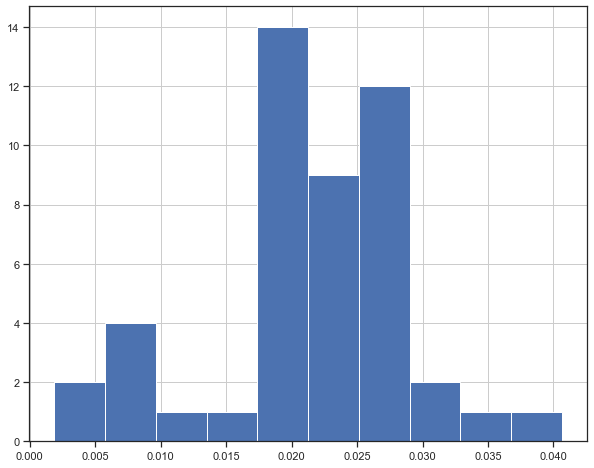

In [62]:
pd.Series(sel.estimator_.feature_importances_.ravel()).hist()


Plotting the distribution of importance - It will return a histogram showing the distribution of the features selected using this feature selection technique.

In [35]:
for cat_feature in ['weekday', 'hour']:
    df_hour = pd.concat([df_hour, pd.get_dummies(df_hour[cat_feature])], axis=1)
    df_30min = pd.concat([df_30min, pd.get_dummies(df_30min[cat_feature])], axis=1)
    df = pd.concat([df, pd.get_dummies(df[cat_feature])], axis=1)

Next, we developed three models, namely Linear Regression Model, Support Vector Regression Model and Random Forest Regressor Model. For the linear regression model, we chose independent features but highly correlated with appliances consumption, based on Pearson correlation and the 2 qualitative predictors 'low_consum','high_consum'.For the SVR model,we chose variables based on the results of the above-mentioned random forest model plus the 2 qualitative predictors.For the random forest model, we chose a combination of viarables with the best results after several tryouts, based on the linearity and correlation assumptions.

In [36]:
# Linear model
model1 = ['low_consum','high_consum','hour','t6','rh_6','lights','hour*lights','windspeed','t6rh6']

#SVR model
model2=['hour', 'low_consum', 'high_consum', 't3','t5','rh_3','t8','rh_2','t4','tdewpoint','t_out','rh_5','lights',
        'rh_8','rh_1','t7','t2','rh_6','press_mm_hg','rh_4','t6','rh_7','t9','rh_out','visibility','rh_9','t1','windspeed']

# RF model
model3 = ['low_consum','high_consum','hour','t6','rh_6','lights','hour*lights','tdewpoint','visibility','press_mm_hg','windspeed']

In [37]:
# to avoid warnings from standardscaler
df_hour.lights = df_hour.lights.astype(float)
df_hour.log_appliances = df_hour.log_appliances.astype(float)
df_hour.hour = df_hour.hour.astype(float)
df_hour.low_consum = df_hour.low_consum.astype(float)
df_hour.high_consum = df_hour.high_consum.astype(float)
df_hour.t6rh6 = df_hour.t6rh6.astype(float)

In [38]:
# Creation of train/test sets for each model

test_size=.2
test_index = int(len(df_hour.dropna())*(1-test_size))

# Linear model
X1_train, X1_test = df_hour[model1].iloc[:test_index,], df_hour[model1].iloc[test_index:,]
y1_train = df_hour.log_appliances.iloc[:test_index,]

#SVR model
X2_train, X2_test = df_hour[model2].iloc[:test_index,], df_hour[model2].iloc[test_index:,]
y2_train = df_hour.log_appliances.iloc[:test_index,]

# RF model
X3_train, X3_test = df_hour[model3].iloc[:test_index,], df_hour[model3].iloc[test_index:,]
y3_train = df_hour.log_appliances.iloc[:test_index,]

y_test =  df_hour.log_appliances.iloc[test_index:,]

In [39]:
from sklearn.preprocessing import StandardScaler

# Normalizing of X matrices for each model to mean = 0 and standard deviation = 1

scaler = StandardScaler()
scaler.fit(X1_train)
X1_train = scaler.transform(X1_train)
X1_test = scaler.transform(X1_test)

scaler.fit(X2_train)
X2_train = scaler.transform(X2_train)
X2_test = scaler.transform(X2_test)

scaler.fit(X3_train)
X3_train = scaler.transform(X3_train)
X3_test = scaler.transform(X3_test)

In [40]:
from sklearn import linear_model

lin_model = linear_model.LinearRegression()
lin_model.fit(X1_train,y1_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [41]:
from sklearn import svm

svr_model = svm.SVR(gamma='scale')
svr_model.fit(X2_train,y2_train)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [42]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=100,random_state=1)            
rf_model.fit(X3_train, y3_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=1, verbose=0,
                      warm_start=False)

# Model Selection and Evaluation

In [43]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import metrics

In [44]:
# Function to evaluate the models

def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    r_score = 100*r2_score(test_labels,predictions)
    accuracy = 100 - mape
    print(model,'\n')
    print('Average Error       : {:0.4f} degrees'.format(np.mean(errors)))
    print('Variance score R^2  : {:0.2f}%' .format(r_score))
    print('Accuracy            : {:0.2f}%\n'.format(accuracy))

In [45]:
lin_reg=evaluate(lin_model, X1_test, y_test)
svr_reg=evaluate(svr_model, X2_test, y_test)
random_for=evaluate(rf_model, X3_test, y_test)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False) 

Average Error       : 0.3093 degrees
Variance score R^2  : 28.15%
Accuracy            : 92.92%

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False) 

Average Error       : 0.3319 degrees
Variance score R^2  : 27.37%
Accuracy            : 92.41%

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=1, verbose=0,
                      warm_start=False) 

Average Error       : 0.2087 degrees
Variance score R^2  : 64.95%
Accuracy            : 95.34%



As shown above, Random Forest Regressor performed significantly better than the other two models with Variance score (R^2) being 64.95% and Accuracy being 95.34%.

Furthermore, We used timeseries Split Cross Validation on all the three models 

In [46]:
#Instead of KFold we use TimeSeriesSplit (10 splits) as the data is Time Series
cv = TimeSeriesSplit(n_splits = 10)


print('Linear Model:')
scores = cross_val_score(lin_model, X1_train, y1_train, cv=cv,scoring='neg_mean_absolute_error')
print("Accuracy: %0.2f (+/- %0.2f) degrees" % (100+scores.mean(), scores.std() * 2))
scores = cross_val_score(lin_model, X1_train, y1_train, cv=cv,scoring='r2')
print("R^2: %0.2f (+/- %0.2f) degrees" % (scores.mean(), scores.std() * 2))


 
print('SVR Model:')
scores = cross_val_score(svr_model, X2_train, y2_train, cv=cv,scoring='neg_mean_absolute_error')
print("Accuracy: %0.2f (+/- %0.2f) degrees" % (100+scores.mean(), scores.std() * 2))
scores = cross_val_score(svr_model, X2_train, y2_train, cv=cv)
print("R^2: %0.2f (+/- %0.2f) degrees" % (scores.mean(), scores.std() * 2))


print('Random Forest Model:')
scores = cross_val_score(rf_model, X3_train, y3_train, cv=cv,scoring='neg_mean_absolute_error')
print("Accuracy: %0.2f (+/- %0.2f) degrees" % (100+scores.mean(), scores.std() * 2))
scores = cross_val_score(rf_model, X3_train, y3_train, cv=cv)
print("R^2: %0.2f (+/- %0.2f) degrees" % (scores.mean(), scores.std() * 2))

Linear Model:
Accuracy: 99.64 (+/- 0.07) degrees
R^2: 0.27 (+/- 0.18) degrees
SVR Model:
Accuracy: 99.69 (+/- 0.11) degrees
R^2: 0.48 (+/- 0.19) degrees
Random Forest Model:
Accuracy: 99.72 (+/- 0.20) degrees
R^2: 0.55 (+/- 0.43) degrees


From the above results, the Random Forest Model is the best of the three, having highest R^2 value and accuracy being almost the same for all the three models.We can notice that there is a significant increase in the accuracy by approximately 6.5% for all the three models.

In [47]:
y1_pred = lin_model.predict(X1_test)
y2_pred = svr_model.predict(X2_test)
y3_pred = rf_model.predict(X3_test)

Text(0.5, 0.01, 'Fitted Values')

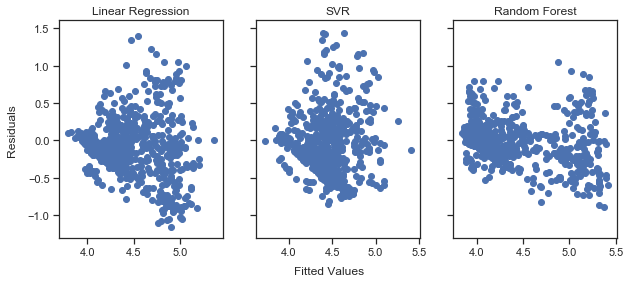

In [48]:
fig, axs = plt.subplots(1, 3, figsize=(10,4), sharey=True)
axs[0].scatter(y1_pred,y_test-y1_pred)
axs[0].set_title('Linear Regression')
axs[1].scatter(y2_pred,y_test-y2_pred)
axs[1].set_title('SVR')
axs[2].scatter(y3_pred,y_test-y3_pred)
axs[2].set_title('Random Forest')
fig.text(0.06, 0.5, 'Residuals', ha='center', va='center', rotation='vertical')
fig.text(0.5, 0.01,'Fitted Values', ha='center', va='center')

We can see that only RF model has random residuals with mean=0 and constant standard deviation.

Text(0.5, 0.01, 'True Values')

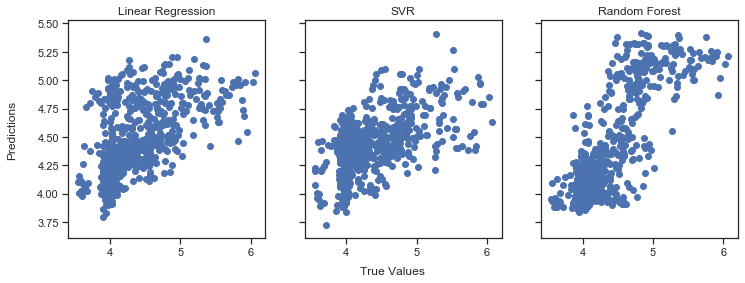

In [60]:
fig, axs = plt.subplots(1, 3, figsize=(12,4), sharey=True)
axs[0].scatter(y_test,y1_pred)
axs[0].set_title('Linear Regression')
axs[1].scatter(y_test,y2_pred)
axs[1].set_title('SVR')
axs[2].scatter(y_test, y3_pred)
axs[2].set_title('Random Forest')
fig.text(0.06, 0.5, 'Predictions', ha='center', va='center', rotation='vertical')
fig.text(0.5, 0.01,'True Values', ha='center', va='center')

 RF model seems to be the only one which predicts high values of electricity consumption.



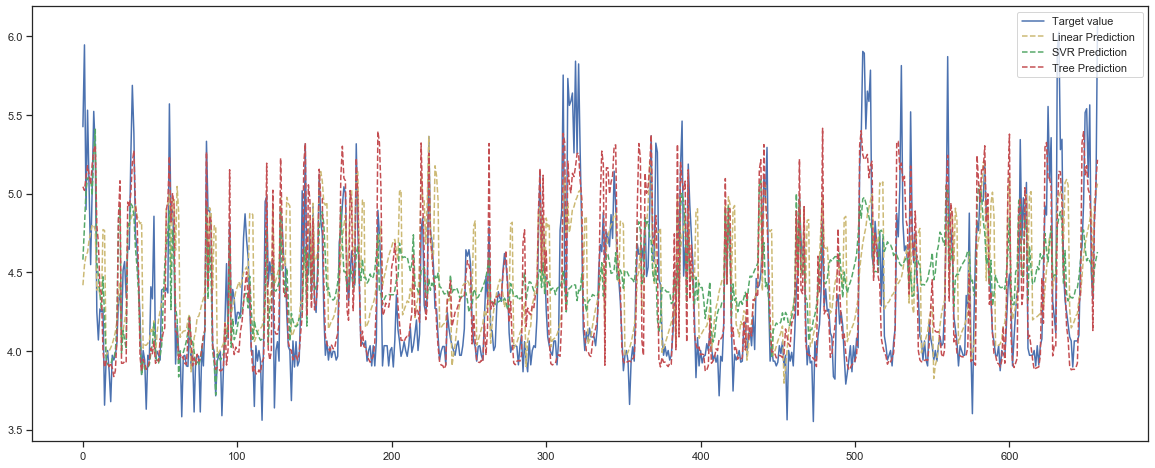

In [50]:
fig = plt.figure(figsize=(20,8))
plt.plot(y_test.values,label='Target value',color='b')
plt.plot(y1_pred,label='Linear Prediction ', linestyle='--', color='y')
plt.plot(y2_pred,label='SVR Prediction ', linestyle='--', color='g')

plt.plot(y3_pred,label='Tree Prediction ', linestyle='--', color='r')


plt.legend(loc=1)

1. feature 2 hour (0.472602)
2. feature 1 high_consum (0.193634)
3. feature 4 rh_6 (0.059657)
4. feature 9 press_mm_hg (0.046690)
5. feature 0 low_consum (0.046142)
6. feature 3 t6 (0.038654)
7. feature 7 tdewpoint (0.038355)
8. feature 6 hour*lights (0.038073)
9. feature 10 windspeed (0.028422)
10. feature 8 visibility (0.025814)
11. feature 5 lights (0.011957)


(-1, 11)

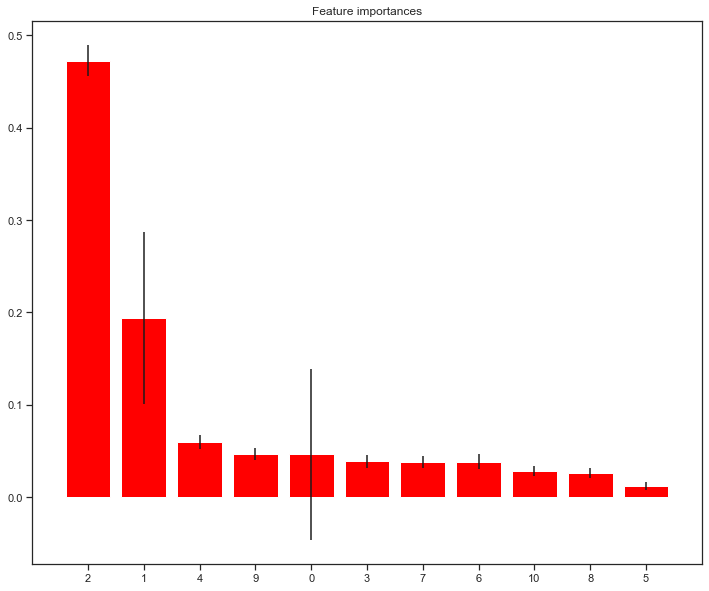

In [70]:
# Feature importances of RF model
importances = rf_model.feature_importances_

std = np.std([tree.feature_importances_ for tree in rf_model.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

for f in range(df_hour[model3].shape[1]):
    print("%d. feature %d %s (%f)" % (f + 1, indices[f], model3[indices[f]], importances[indices[f]]))

# Plot the feature importances of the RF model
plt.figure(figsize=(12, 10))
plt.title("Feature importances")
plt.bar(range(df_hour[model3].shape[1]), importances[indices],
       color="red", yerr=std[indices], align="center")
plt.xticks(range(df_hour[model3].shape[1]), indices)
plt.xlim([-1, df_hour[model3].shape[1]])

# Optimizing Model Performance

In order to optimize the variance score of RF model, Parameter tuning was executed using GridsearchCV.

In [52]:
from sklearn.model_selection import GridSearchCV, KFold


parameters = {

    'max_depth': [800,1000,1500],
    'min_samples_leaf': [5,8,10],
    'min_samples_split': [5,10,15],
    'n_estimators': [40,60,100],
    'random_state':[1]
    
}

cv =cv
grid_model = GridSearchCV(RandomForestRegressor(), parameters, cv=cv)

grid_model = grid_model.fit(X3_train, y3_train)
print(grid_model.best_estimator_)
print(grid_model.best_params_)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=800,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=10, min_samples_split=5,
                      min_weight_fraction_leaf=0.0, n_estimators=60,
                      n_jobs=None, oob_score=False, random_state=1, verbose=0,
                      warm_start=False)
{'max_depth': 800, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 60, 'random_state': 1}


In [53]:
best_rf_model = grid_model.best_estimator_
grid_accuracy = evaluate(grid_model, X3_test, y_test)

GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=10),
             error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=N

We evaluated the model and observed significant increase in the variance score from 54.95% to 68.21%.

In [54]:
y_best_pred = best_rf_model.predict(X3_test)

In [55]:
# Calculate Confidence interval 95% for the predictions
sum_errs = np.sum((y_test - y_best_pred)**2)
stdev = np.sqrt(1/(len(df_hour)-2) * sum_errs)

interval = 1.96 * stdev #95% CI

lower, upper = y_best_pred - interval, y_best_pred + interval

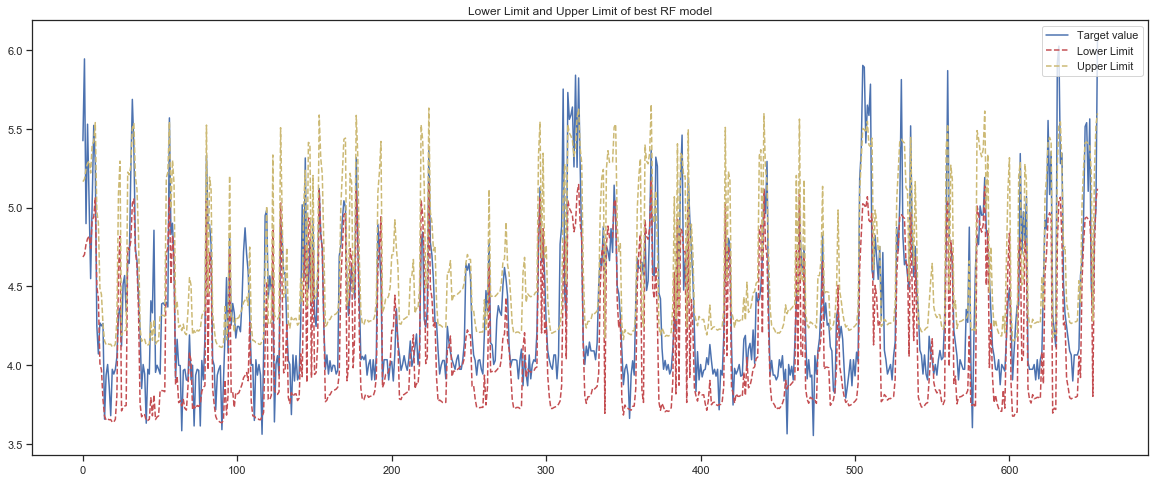

In [56]:
# Plot final predictions on test set based on best RF model
fig = plt.figure(figsize=(20,8))
plt.plot(y_test.values,label='Target value',color='b')
#plt.plot(y_pred,label='Best Tree Prediction ', linestyle='-', color='b')
plt.plot(lower,label='Lower Limit ', linestyle='--', color='r')
plt.plot(upper,label='Upper Limit ', linestyle='--', color='y')
plt.title('Lower Limit and Upper Limit of best RF model')

plt.legend(loc=1)

From the above plot we can notice that our model fails to predict only values of power consumption that are over (exp(5.7)=) 300Wh, which are very rare.



# Conclusion

From the above analysis, we concluded that Random Forest Regression should be used to predict the target variance-Appliance electricity usage.

For further analysis, we can implement MLP Regressor, XGBoost, Multiple random forest regression models using different combinations of feature engineering to explore the best suited model for Appliance energy usage prediction. 